In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from torch.autograd import Variable
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,BertModel
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional
import transformers

np.random.RandomState(seed=1)

RandomState(MT19937) at 0x169CC7C40

# Проверка модели

Обучим лучшую модель на данных без выбросов:

num_div_text_LogisticRegr 

Параметры:
LogReg: {'warm_start': False, 'tol': 0.001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'intercept_scaling': 1, 'fit_intercept': False, 'dual': False, 'class_weight': 'balanced', 'C': 1}

In [39]:
# результаты обучения каждой модели будут записываться в results
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', '2*roc_auc-1', 'thrs', 'predicted'])
def evaluation(model_name, val, predicted, thrs=0.5):
    '''
    На вход - имя модели и метки, получившиеся после обучения модели, и метки валидационной выборки
    Возвращает таблицу с результатами results + столбец predicted с предсказаниями модели для валидационного датасета 
    (для сохранения данных)
    '''
    
    acc = metrics.accuracy_score(val, (predicted>thrs))
    pr = metrics.precision_score(val, (predicted>thrs))
    rec = metrics.recall_score(val, (predicted>thrs))
    f1 = metrics.f1_score(val, (predicted>thrs))
    roc_auc = metrics.roc_auc_score(val, predicted)
    roc_norm = roc_auc * 2 - 1
    
    results.loc[len(results)] = [model_name, acc, pr, rec, f1, roc_auc, roc_norm, thrs, predicted]

    
def plot(model_name, predicted, val, thrs=0.5):
    '''
    Рисует для конкретной модели roc и предсказания модели
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(val, predicted)
    
    A = np.array(predicted)
    idx_sig = np.where(val == 1)[0]
    idx_bkg = np.where(val == 0)[0]
    bins = 10
    
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    plt.plot(fpr,  tpr, '.')
    plt.title(model_name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    ax2 = plt.subplot(1,2,2)
    plt.hist(A[idx_sig], histtype='step', label='1', density=True, bins = bins)
    plt.hist(A[idx_bkg], histtype='step', label='0', density=True, bins = bins)
    plt.vlines(x=thrs, ymin=0, ymax=4, color='red', linestyle='--', label = 'threshold')
    plt.xlabel('prediction')
    plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
    plt.legend(loc="upper right")
    plt.title(model_name)
    plt.show()
    plt.close('all') 


In [40]:
def models(model_feature, x_train, y_train, x_val, y_val, thrs=0.5):
    '''
    Функция обучает 2 модели (с произвольными параметрами) на данных, результаты по валидации добавляются в таблицу results
    '''
    #3. Logistic regression
    print('---Logistic regression---')
    model = LogisticRegression(warm_start = False, tol= 0.001, solver= 'liblinear', penalty= 'l1', 
                               max_iter= 1000, intercept_scaling= 1, fit_intercept= False, dual= False, 
                               class_weight= 'balanced', C= 1)
    model.fit(x_train, y_train)
    preds_proba = model.predict_proba(x_val)
    preds_proba1 = preds_proba[:, 1]
    evaluation(model_feature + '_LogisticRegr', y_val, preds_proba1, thrs)    

In [41]:
def plot_results():
    '''
    Рисует для всех моделей из results roc и предсказания
    '''
    preds = results.predicted.values
    name = results.model.values
    thrs = results.thrs.values
    for i in range(len(results)):
        plot(str(i) + ':' + name[i], preds[i], y_val, thrs[i])

In [42]:
#убираем дубликаты, id и выбросы
data = pd.read_csv('/Users/nzaretski/Desktop/education/wildberies/script/wb_school/data/data_analysis.csv')
data = data[data.duplicated() == False].reset_index(drop=True)
data.drop(['id1', 'id2', 'id3'], axis=1, inplace=True)
data.head(2)

data = data[data.f1 <220]

data = data[data.f2 <180]

data = data[data.f4 <7000]

data = data[data.f5 <3000]

data = data[data.f7 <400]

data = data[data.f8 <2000]
data.reset_index(inplace=True, drop=True)

In [43]:
#checkpoint
data_in = data.copy()

In [44]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [45]:
df_train.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,"сапожники хорошого качества, зелёный немного п...",10,10,5.0,828,187,4.822464,55,57,0
1,Хорошая вместительная сумка! Спокойно уместила...,1,1,5.0,8,6,4.500000,4,4,0


# 1. Baseline

In [46]:
# id1 - покупатель
# id2 - товар
# id3 - продавец
# f1 - количество отзывов (id1)
# f2 - (id1)
# f3 - средний отзыв пользователя(id1)
# f4 - количество продаж (id2)
# f5 - количество фото в комментариях(id2)
# f6 - средняя оценка товара (id2)
# f7 - количество выкупов
# f8 - количество заказов


#f7 / f8 - доля выкупа

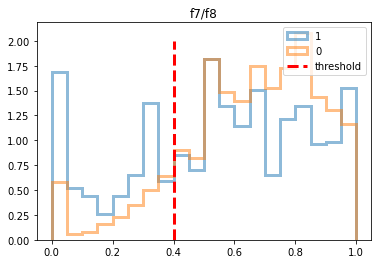

In [47]:
plt.hist(data.f7[data.label==1] / data.f8[data.label==1], bins=20, alpha=0.5, label='1', density=True, histtype = 'step', linewidth=3)
plt.hist(data.f7[data.label==0] / data.f8[data.label==0], bins=20, alpha=0.5, label='0', density=True, histtype = 'step', linewidth=3)
plt.vlines(x=0.4, ymin=0, ymax=2, color='red', linewidth=3, linestyle='--', label='threshold')
plt.legend()
plt.title('f7/f8')
plt.show()

In [48]:
y = df_val.label.values
preds = df_val.f7 / df_val.f8 < 0.4
preds = np.array(preds.replace({False:0, True:1}))

In [49]:
evaluation('baseline', y, preds)
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,baseline,0.708609,0.385714,0.232759,0.290323,0.552581,0.105162,0.5,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."


## f1-f8, деление + текст

In [50]:
cols = list(data.columns)
cols.remove('label')
cols.remove('text')
print(cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']


In [51]:
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        #деление не выполняется на признак с нулевыми значениями
        if len(data[cols[j]][data[cols[j]]==0].values) == 0:
            name = 'div_' + cols[i] + '_' + cols[j]
            data[name] = data[cols[i]] / data[cols[j]]

In [52]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f2_f8,div_f3_f4,div_f3_f6,div_f3_f8,div_f4_f6,div_f4_f8,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,0.027778,0.090909,0.234043,0.027778,2.574468,0.305556,3.042553,0.361111,0.118687,0.500000
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,0.055046,0.058696,0.608824,0.024771,10.372549,0.422018,0.901961,0.036697,0.040686,0.825688


In [53]:
# количество знаков препининия
data['num_points'] = data.text.apply(lambda x: x.count(',') + x.count(';') \
                                   + x.count(':')+ x.count('.')+ x.count('!')+ x.count('?')\
                                   + x.count('"')+ x.count("'")+ x.count('/'))

In [54]:
# убираем знаки препинания и все, кроме русского текста
from string import digits, whitespace
import re

cyrillic_letters = "абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"

def tokenizer(text):
    text = text.replace(',', ' ')
    text = text.replace(':', ' ')
    text = text.replace(';', ' ')
    text = text.replace('.', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('"', ' ')
    text = text.replace("'", ' ')
    text = text.replace('/', ' ')
    allowed_chars = cyrillic_letters + digits + whitespace
    return re.sub("\s\s+", " ", "".join([c for c in text if c in allowed_chars])).strip()

# data.text = data.text.apply(lambda x: tokenizer(x.lower()))
data.text = data.text.apply(lambda x: tokenizer(x))

In [55]:
#количество слов, начинающихся с большой буквы
def big_letter(x):
    counter = 0
    for word in x.split():
        if word[0].upper() == word[0]:
            counter+=1
    return counter

data['num_big_letters'] = data.text.apply(lambda x: big_letter(x))
data.text = data.text.apply(lambda x: x.lower())

In [56]:
# средняя длина слова, количество стоп-слов, количество слов
def avg_word_len(x): # x - string
    x = x.split()
    lens = []
    if len(x) == 0:
        return 0
    for i in x:
        lens.append(len(i))
    return np.mean(lens)

data['avg_word_len'] = data.text.apply(avg_word_len)
data['num_words'] = data.text.apply(lambda x: len(x.split()))

In [57]:
# пустые комментарии после "чистки" 
data[data.num_words==0]

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f4_f6,div_f4_f8,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8,num_points,num_big_letters,avg_word_len,num_words
23,,8,7,5.000000,96,27,4.520833,12,13,1,...,21.235023,7.384615,5.972350,2.076923,0.347756,0.923077,0,0,0.0,0
395,,2,2,2.500000,27,3,4.111111,3,6,1,...,6.567568,4.500000,0.729730,0.500000,0.685185,0.500000,0,0,0.0,0
618,,13,13,4.846154,881,175,4.611805,84,127,0,...,191.031504,6.937008,37.946099,1.377953,0.036313,0.661417,0,0,0.0,0
1179,,6,6,5.000000,17,1,4.235294,9,14,0,...,4.013889,1.214286,0.236111,0.071429,0.302521,0.642857,0,0,0.0,0
2220,,1,1,5.000000,3,0,3.666667,6,14,1,...,0.818182,0.214286,0.000000,0.000000,0.261905,0.428571,0,0,0.0,0


In [58]:
data['avg_big_letters'] = data.num_big_letters / data.num_words
data['avg_points'] = data.num_points / data.num_words

# так как комментарий может быть пустой, появятся nan при вычислении средних - заменим их нулями
data = data.fillna(0)

In [59]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points
0,хотела купить на замену старых по итогу эти уж...,1,1,1.0,11,13,4.272727,18,36,0,...,3.042553,0.361111,0.118687,0.500000,5,1,4.750000,16,0.062500,0.312500
1,запах по сравнению с обычным никакой оно не па...,10,6,2.7,46,4,4.434783,90,109,1,...,0.901961,0.036697,0.040686,0.825688,2,3,5.642857,14,0.214286,0.142857


In [60]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [61]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_div_text', X_train, y_train, X_val, y_val)

---Logistic regression---


In [62]:
results = results.sort_values(by=['roc_auc', 'precision', 'f1'], ascending=False)

In [63]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
1,num_f1_f8_div_text_LogisticRegr,0.688742,0.407407,0.474138,0.438247,0.668653,0.337307,0.5,"[0.29773863547073603, 0.9325523336374785, 0.66..."
0,baseline,0.708609,0.385714,0.232759,0.290323,0.552581,0.105162,0.5,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."


In [84]:
# по результатам: деление числовых признаков друг на друга вносит вклад

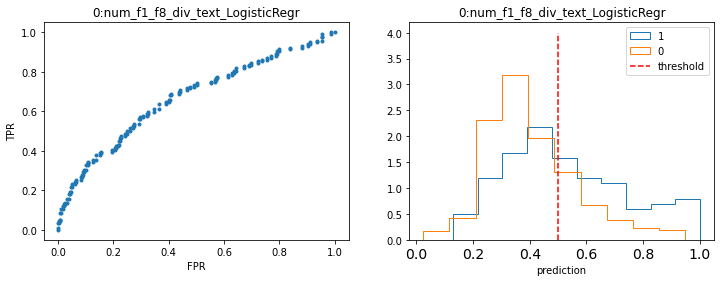

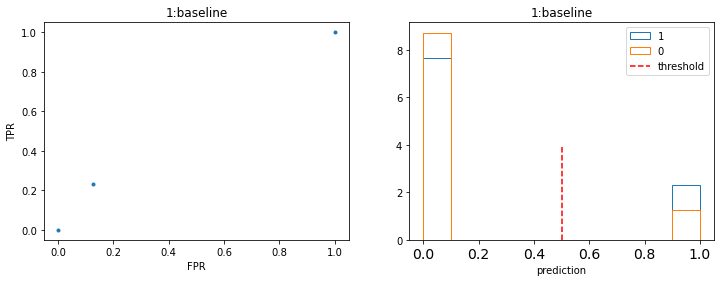

In [64]:
plot_results()

# Вывод: лучше не стало, поэтому выбросы удалять не следует, так как они могут содержать дополнительный признаки, не мешая обучению модели